Project 3: A Deep Learning Toy Model for Video Compression
===

In this project, we will use simple deep learning networks for basic video compression.

For this project, we are going to use a template that's mostly from project 2. The reason is that a video is essentially a sequence of images, in which case a network for image compression is much likely to be re-usable for video compression.

---

## 1. Objectives, Requirements and Others

### 1.1 Objectives

* Customize your model and training process for better performance -- High PSNR on test videos.
* Make sure the model complexity not too high and compression ratio not too low.

### 1.2 Requirements

* Project 3 is an **Individual Project**. 
* **Training data** can only be the data under `Image` and `Video/train` folders that provided.
* Time limit applys for the overall training process: **30 mins**
* Model limit: there's a **benchmark test** at the end of this notebook. It includes model complexity test and compression ratio test. Please **test your model with this and make sure it satisfies the requirement both in complexity and compression ratio**. 
* **NO pre-trained model**. You are supposed to train the network from scratch. 

### 1.3 Submission

Each student is supposed to upload a **{YOUR_FIRST_NAME}_{YOUR_UNIKEY}.zip** (e.g. Sydney_haha2333.zip) file with three files:

* **a jupyternotebook** with the complete training and testing details of your final model. In other words, it is expected to reproduce the complete experiment process and reproduce the result on ```test``` test of your final model.
* **a txt file** contains a Google drive link, which links to your final model's checkpoint (the trained parameter).
* **a PDF report** contains at least the following section:
  * Introduction
  * Method
  * Experiment & Analysis
  * Conclusion
  * (Further details are strongly encouraged, especially experiment analysis and the novelty of the method)
  * (Tables and Figures are encouraged)

### 1.4 Marking Scheme
* Code -- 25%
  * the submitted code could run without error (except the path to the dataset) -- 15%
  * the complete experimental output and log of each code cell -- 5%
  * proper comment that makes the code easy to read -- 5%

* PDF report -- 50%
  * well-written Introduction -- 10%
  * detailed discription of the method (e.g. includes an overview of the network structure of your method) -- 15%
  * detailed in-depth **quantitative** and **qualitative** analysis (e.g. tables and figures of results, how you go from baseline to the final model step-by-step and how each step affects the performance) -- 15%
  * good performance of the model -- 10%

* Presentation -- 25% 
  * easy-to-follow presentation -- 10%
  * detailed in-depth **quantitative** and **qualitative** analysis -- 15%



---
* The best performance network is Modified Network7 (max PSNR = 36.8 trained for 28 min).

* The checkpoint could be downloaded from: https://drive.google.com/drive/folders/1WMbrkttehoT6Xje5cfU24adG3E0sIMLd?usp=sharing

* And in the last section (Section 27), the checkpoint is used to visulize 3 random images in the test set.

* To run this code, Run Section 2.2, 2.3, 2.1 first to upload the datasets needed.
Then run Section3, Section 5 for functions needed.
And Section 7.1, 7.2 will import the benchmark test.

* And if you any questions, please email Hangyu Chen (hche4847@uni.sydney.edu.au)

---

## 2. Preparation for the experiments

Data loading and GPU preparation

### 2.1 Preliminary: Conversion between images and videos

A video is essentially a sequence of consecutive images. We can convert a video to images and vice versa. Here is an example.

In [ ]:
# convert image sequence to a video

import os
import cv2
import glob
import numpy as np
 
path_to_sequence = '/content/drive/MyDrive/ELEC5306-2022/Video/train/Bird2/img'
img_array = []

# remember to sort the images before conversion, 
# otherwise they might be in wrong temporal order
for filename in sorted(glob.glob(os.path.join(path_to_sequence, '*.jpg'))):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
out = cv2.VideoWriter('/content/drive/MyDrive/ELEC5306-2022/Video/train/Bird2/video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print('success')

success


In [ ]:
# convert video to image sequence

def getFrame(vid_path, out_dir):
    vidcap = cv2.VideoCapture(vid_path)
    hasFrames = True
    count = 0
    while hasFrames:
      hasFrames,image = vidcap.read()
      if hasFrames:
        cv2.imwrite(os.path.join(out_dir, "image_"+str(count)+".jpg"), image)     # save frame as JPG file
        count += 1
      else:
        print('end of sequence')
        break

getFrame(
    '/content/drive/MyDrive/ELEC5306-2022/Video/train/Bird2/video.mp4',
    '/content/drive/MyDrive/ELEC5306-2022/Video/train/Bird2/img_from_video')


end of sequence


### 2.2 Get GPU ready

Change Runtime Type in the Colab menu to 'GPU'.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from torchvision import datasets

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from torch.utils.data import Dataset


print(torch.cuda.is_available()) # check if cuda is avaliable so that we could use GPU

True


In [2]:
!nvidia-smi

Sun Jun  5 08:21:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 2.3 Prepare the data

The video data for train/test is at https://drive.google.com/drive/folders/1-3jkYvdTxxJmLG4WSps95w55_GL7naBc?usp=sharing.

The image data for training is at https://drive.google.com/drive/folders/1--iDlKbCuD4bYmSXUj7CrP-u4EezqGyv?usp=sharing. 

**NOTE:** 

1. The image data part is exactly the same training data used for project 2
2. **ONLY data in image and video/train can be used for training**, no other sources allowed.

Step-by-step

1. Put those folder (and the data inside of course) in your GoogleDrive.
2. Run the command below to mount the GoogleDrive onto Colab.
3. Check the path to the data (e.g. `'/content/drive/MyDrive/MYDATA'`), and we will use this later.

Hint: you can check the file with either bash command or use the leftmost sidebar in Colab, there's a folder shaped icon.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check the data: When you do `!ls YOUR_DATA_PATH`, you should see `train` and `valid` under the dir.

In [ ]:
!ls /content/drive/MyDrive/ELEC5306-2022/

Image  valid  Video


---

## 3. Functions needed

Import all the functions needed

Let's firt import packages for this project. 

In [ ]:
# ################################################
# import packages

import argparse
import time
import math
import random
import shutil
import sys
import glob

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset


Then we define a Dataset class that could iterate over images under a directory. 

In [ ]:
# ################################################
# ImageFolder Dataset

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
    """

    def __init__(self, root, transform=None):
        splitdir = Path(root)

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)

In [ ]:
# ################################################
# SequenceFolder Dataset

class SequenceFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
              - video 1
                - img000.png
                - img001.png
                ...
              - video 2
                - img000.png
                - img001.png
                ...
            - test/
              - video 1
                - img000.png
                - img001.png
                ...
              - video 2
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        self.mode = split
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = self.get_all_images(splitdir)

        self.transform = transform

    def get_all_images(self, direc):
        self.images = []
        self.image_sequence = []
        self.sequences = [f for f in direc.iterdir() if f.is_dir()]
        for sd in self.sequences:
            images = []
            for f in (sd / 'img').iterdir():
                if f.is_file():
                  images.append(f)
            self.image_sequence.append(images)
            self.images = self.images + list(sorted(images))

        return self.images

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)

In [ ]:
# d = SequenceFolder('/content/drive/MyDrive/ELEC5306-2022/Video')
# d.image_sequence

---
## 4. Baseline Network define

Then let's define a baseline neural network.

**NOTE:**

As in the requirement, please use the ```benchmark``` function at the end of this template to check your model's complexity and compression ratio, and see if both meet the requirement.

In [ ]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        return {"x_hat": x_hat}


Define some arguments useful for training/validation.

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 64
M = 96

---
## 5. Here are some other ingredients for training and testing.

In [ ]:
class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [ ]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [ ]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

In [ ]:
def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    # img1 shape: (B, C, H, W)
    # img2 shape: (B, C, H, W)
    
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))

After we almost got everything we need, we define a `train_one_epoch` function for training the model for one epoch.

In [ ]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


Likewise we further define a `test_epoch` function. 

Unlike project 2, this time the metric is measured on videos instead of images.

In [ ]:
def test_epoch(epoch, test_dataset, transform, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    mse_loss = AverageMeter()
    psnr = AverageMeter()

    with torch.no_grad():
        for video in test_dataset.image_sequence:
            psnr_video = AverageMeter()
            for image in video:
                image = Image.open(image).convert("RGB")
                image = transform(image)
                d = image.to(device).unsqueeze(0)
                out_net = model(d)
                d_out = out_net['x_hat']
                out_criterion = criterion(out_net, d)
                psnr_video.update(PSNR(d, d_out))

            mse_loss.update(out_criterion["mse_loss"])
            psnr.update(psnr_video.avg)

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tMSE loss: {mse_loss.avg:.3f}"
        f'\tSequence-wise PSNR: {psnr.avg: .3f}\n'
    )

    return mse_loss.avg,psnr.avg

Finally we define a main function, and complete the whole training/testing process.

At the start of this main function, we define some arguments that's useful for training.

In [ ]:
!ls drive/MyDrive/ELEC5306-2022

Image  valid  Video


---
## 6. Baseline Training
max PSNR: 27.644

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 1513.246 |	MSE loss: 5.934
Train epoch 0: [160/250 (62%)]	Loss: 103.313 |	MSE loss: 0.405
Test epoch 0: Average losses:	MSE loss: 0.161	Sequence-wise PSNR:  8.087

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 43.844 |	MSE loss: 0.172
Train epoch 1: [160/250 (62%)]	Loss: 35.154 |	MSE loss: 0.138
Test epoch 1: Average losses:	MSE loss: 0.080	Sequence-wise PSNR:  11.065

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 25.329 |	MSE loss: 0.099
Train epoch 2: [160/250 (62%)]	Loss: 13.164 |	MSE loss: 0.052
Test epoch 2: Average losses:	MSE loss: 0.178	Sequence-wise PSNR:  8.368

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 62.548 |	MSE loss: 0.245
Train epoch 3: [160/250 (62%)]	Loss: 11.672 |	MSE loss: 0.046
Test epoch 3: Average losses:	MSE loss: 0.060	Sequence-wise PSNR:  12.651

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 20.030 |	MSE loss: 0.079
Train epoch 4: [160/250 (62%)]	Loss: 13.917 |	MSE l

In [ ]:
print(type(train_time.sum))

<class 'float'>


In [ ]:
# print the results
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
<class 'list'>
[tensor(0.1610, device='cuda:0'), tensor(0.0796, device='cuda:0'), tensor(0.1785, device='cuda:0'), tensor(0.0602, device='cuda:0'), tensor(0.0382, device='cuda:0'), tensor(0.0255, device='cuda:0'), tensor(0.0224, device='cuda:0'), tensor(0.0203, device='cuda:0'), tensor(0.0499, device='cuda:0'), tensor(0.0309, device='cuda:0'), tensor(0.0169, device='cuda:0'), tensor(0.0149, device='cuda:0'), tensor(0.0197, device='cuda:0'), tensor(0.0230, device='cuda:0'), tensor(0.0143, device='cuda:0'), tensor(0.0136, device='cuda:0'), tensor(0.0125, device='cuda:0'), tensor(0.0118, device='cuda:0'

The max PSNR is:  27.64430809020996


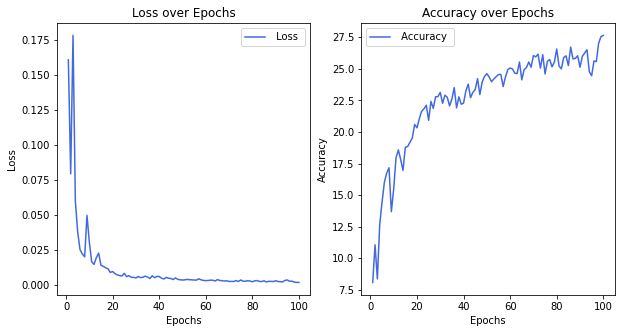

In [ ]:
# plot the curves
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

---
## 7. Benchmark Test

**Make sure your model has ``compress`` method like the one in the example network**

please make sure your model can get through this benchmark, in which case it prints ``you can move on :)``. 

Otherwise refer to the output for the guidance to adjust your network.

In [ ]:
!pip install pthflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pthflops import count_ops

MAX_GFLOPS = 3000
MIN_RATIO = 0.7

def benchmark(yournet):
    yournet = yournet.cuda()
    x = torch.randn((1, 3, 500, 500)).cuda()
    try:
      yournet.compress(x)
    except AttributeError:
      print('does your network have a ```def compress(self, input)``` function?')
      print('refer to the baseline model in the template')
      return

    est, _ = count_ops(yournet, x, print_readable=False, verbose=False)
    est = int(est / 1e9)
    if est <= MAX_GFLOPS:
      print('#' * 30)
      print('[Acceptable Model Complexity]')
      print('#' * 30)
      print('\n')
    else:
      assert 0, 'Your model complexity is {} GFLOPS, the acceptable maximum is {} GFLOPS. Make your model smaller'.format(est, MAX_GFLOPS)

    compressed = yournet.compress(x)
    ratio = 1 - compressed.numel() / x.numel()
    if ratio >= MIN_RATIO:
      print('#' * 30)
      print('[Acceptable Compression Ratio]')
      print('#' * 30)
    else:
      assert 0, 'Current compression ratio is {} , the acceptable lowest ratio is {}. Make it higher'.format(ratio, MIN_RATIO)

    print('you can move on :)')
    return est, ratio

### 7.1 Benchmark for Baseline Network

In [ ]:
# an EXAMPLE network to run the test
yournet = Network(N, M).cuda()
benchmark(yournet)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(12, 0.868928)

### 7.2 The Benchmark for Modified Networks is shown at the bottom of each Modified Network

---
## 8. Modified Network 1

max PSNR: 27.249 (40 epochs)

In [ ]:
def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            # nn.Conv2d(3, 64, 3, padding=1),
            # nn.ReLU(),

            # nn.Conv2d(64, 64, 3, 2, padding=0),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64, 3, 3, padding=1)

            conv(3, N),
            
            conv(N, N),
            # nn.BatchNorm2d(N),
            # nn.PReLU(),
            
            
            
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            # deconv(N, N),
            # deconv(N, N),
            # deconv(N, N),
            deconv(N, 3),


            # nn.Conv2d(64, 64 ,3),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64, 64 ,3),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64, 64 ,3),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),

            # nn.Conv2d(64, 3, 3)
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}


In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(3, 0.745984)

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 40                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 32
M = 48

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 20):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 398.234 |	MSE loss: 1.562
Train epoch 0: [160/250 (62%)]	Loss: 33.366 |	MSE loss: 0.131
Test epoch 0: Average losses:	MSE loss: 0.093	Sequence-wise PSNR:  10.564

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 16.059 |	MSE loss: 0.063
Train epoch 1: [160/250 (62%)]	Loss: 12.288 |	MSE loss: 0.048
Test epoch 1: Average losses:	MSE loss: 0.073	Sequence-wise PSNR:  11.636

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 13.270 |	MSE loss: 0.052
Train epoch 2: [160/250 (62%)]	Loss: 10.321 |	MSE loss: 0.040
Test epoch 2: Average losses:	MSE loss: 0.033	Sequence-wise PSNR:  14.896

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 7.534 |	MSE loss: 0.030
Train epoch 3: [160/250 (62%)]	Loss: 5.166 |	MSE loss: 0.020
Test epoch 3: Average losses:	MSE loss: 0.023	Sequence-wise PSNR:  16.512

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 6.848 |	MSE loss: 0.027
Train epoch 4: [160/250 (62%)]	Loss: 6.311 |	MSE loss:

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
<class 'list'>
[tensor(0.0927, device='cuda:0'), tensor(0.0733, device='cuda:0'), tensor(0.0333, device='cuda:0'), tensor(0.0233, device='cuda:0'), tensor(0.0165, device='cuda:0'), tensor(0.0177, device='cuda:0'), tensor(0.0118, device='cuda:0'), tensor(0.0100, device='cuda:0'), tensor(0.0085, device='cuda:0'), tensor(0.0082, device='cuda:0'), tensor(0.0079, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0098, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0042, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(0.0045, device='cuda:0'), tensor(

The max PSNR is:  27.249202728271484


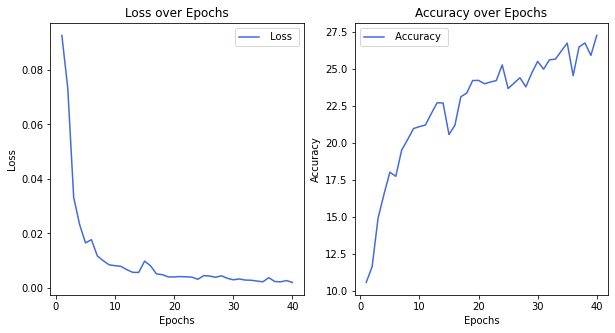

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 9. Modified Network 2
max PSNR: 27.6815 (40 epochs)

In [ ]:
def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, 3),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}


In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(5, 0.714232)

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 40                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 20):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 646.713 |	MSE loss: 2.536
Train epoch 0: [160/250 (62%)]	Loss: 45.970 |	MSE loss: 0.180
Test epoch 0: Average losses:	MSE loss: 0.098	Sequence-wise PSNR:  10.290

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 23.467 |	MSE loss: 0.092
Train epoch 1: [160/250 (62%)]	Loss: 26.409 |	MSE loss: 0.104
Test epoch 1: Average losses:	MSE loss: 0.071	Sequence-wise PSNR:  11.748

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 19.864 |	MSE loss: 0.078
Train epoch 2: [160/250 (62%)]	Loss: 15.488 |	MSE loss: 0.061
Test epoch 2: Average losses:	MSE loss: 0.039	Sequence-wise PSNR:  14.190

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 7.567 |	MSE loss: 0.030
Train epoch 3: [160/250 (62%)]	Loss: 10.060 |	MSE loss: 0.039
Test epoch 3: Average losses:	MSE loss: 0.028	Sequence-wise PSNR:  15.652

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 7.229 |	MSE loss: 0.028
Train epoch 4: [160/250 (62%)]	Loss: 4.395 |	MSE loss

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
<class 'list'>
[tensor(0.0979, device='cuda:0'), tensor(0.0714, device='cuda:0'), tensor(0.0391, device='cuda:0'), tensor(0.0284, device='cuda:0'), tensor(0.0178, device='cuda:0'), tensor(0.0144, device='cuda:0'), tensor(0.0113, device='cuda:0'), tensor(0.0093, device='cuda:0'), tensor(0.0093, device='cuda:0'), tensor(0.0074, device='cuda:0'), tensor(0.0058, device='cuda:0'), tensor(0.0071, device='cuda:0'), tensor(0.0059, device='cuda:0'), tensor(0.0107, device='cuda:0'), tensor(0.0050, device='cuda:0'), tensor(0.0046, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(0.0045, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0036, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0037, device='cuda:0'), tensor(

The max PSNR is:  27.681575775146484


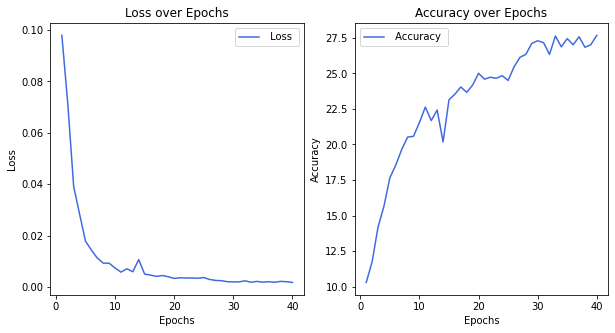

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 10. Modified Network 3
max PSNR: 25.19 (40 epochs)

In [ ]:
def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            # nn.Conv2d(3, 64, 3, padding=1),
            # nn.ReLU(),

            # nn.Conv2d(64, 64, 3, 2, padding=0),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64, 3, 3, padding=1)

            conv(3, N),
            nn.PReLU(),
            conv(N, N),
            # nn.BatchNorm2d(N),
            nn.PReLU(),
            
            
            
            conv(N, M),
            nn.BatchNorm2d(M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            # deconv(N, N),
            # deconv(N, N),
            # deconv(N, N),
            deconv(N, 3),


            # nn.Conv2d(64, 64 ,3),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64, 64 ,3),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.Conv2d(64, 64 ,3),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),

            # nn.Conv2d(64, 3, 3)
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}


In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(5, 0.714232)

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 40                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 20):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 301.664 |	MSE loss: 1.183
Train epoch 0: [160/250 (62%)]	Loss: 13.321 |	MSE loss: 0.052
Test epoch 0: Average losses:	MSE loss: 0.033	Sequence-wise PSNR:  15.044

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 8.082 |	MSE loss: 0.032
Train epoch 1: [160/250 (62%)]	Loss: 11.261 |	MSE loss: 0.044
Test epoch 1: Average losses:	MSE loss: 0.020	Sequence-wise PSNR:  17.289

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 4.518 |	MSE loss: 0.018
Train epoch 2: [160/250 (62%)]	Loss: 6.616 |	MSE loss: 0.026
Test epoch 2: Average losses:	MSE loss: 0.024	Sequence-wise PSNR:  16.643

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 5.367 |	MSE loss: 0.021
Train epoch 3: [160/250 (62%)]	Loss: 4.222 |	MSE loss: 0.017
Test epoch 3: Average losses:	MSE loss: 0.024	Sequence-wise PSNR:  16.762

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 6.366 |	MSE loss: 0.025
Train epoch 4: [160/250 (62%)]	Loss: 4.766 |	MSE loss: 0.

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
<class 'list'>
[tensor(0.0333, device='cuda:0'), tensor(0.0198, device='cuda:0'), tensor(0.0238, device='cuda:0'), tensor(0.0237, device='cuda:0'), tensor(0.0132, device='cuda:0'), tensor(0.0135, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0109, device='cuda:0'), tensor(0.0090, device='cuda:0'), tensor(0.0082, device='cuda:0'), tensor(0.0080, device='cuda:0'), tensor(0.0076, device='cuda:0'), tensor(0.0089, device='cuda:0'), tensor(0.0098, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor(0.0075, device='cuda:0'), tensor(0.0065, device='cuda:0'), tensor(0.0068, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0045, device='cuda:0'), tensor(0.0046, device='cuda:0'), tensor(

The max PSNR is:  25.19012451171875


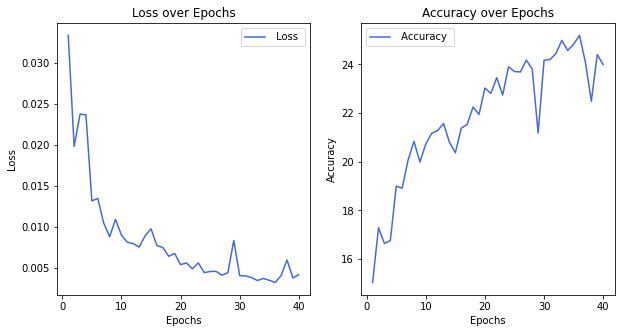

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 11. Modified Network 4

max PSNR = 25.190  (40 epochs)

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            nn.PReLU(),
            conv(N, N),
            nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, 3),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}




In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(5, 0.714232)

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 40                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
# N = 40
# M = 54

N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 25):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 301.664 |	MSE loss: 1.183
Train epoch 0: [160/250 (62%)]	Loss: 13.321 |	MSE loss: 0.052
Test epoch 0: Average losses:	MSE loss: 0.033	Sequence-wise PSNR:  15.044

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 8.082 |	MSE loss: 0.032
Train epoch 1: [160/250 (62%)]	Loss: 11.258 |	MSE loss: 0.044
Test epoch 1: Average losses:	MSE loss: 0.020	Sequence-wise PSNR:  17.268

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 4.557 |	MSE loss: 0.018
Train epoch 2: [160/250 (62%)]	Loss: 6.232 |	MSE loss: 0.024
Test epoch 2: Average losses:	MSE loss: 0.018	Sequence-wise PSNR:  17.741

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 3.543 |	MSE loss: 0.014
Train epoch 3: [160/250 (62%)]	Loss: 3.717 |	MSE loss: 0.015
Test epoch 3: Average losses:	MSE loss: 0.020	Sequence-wise PSNR:  17.455

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 5.780 |	MSE loss: 0.023
Train epoch 4: [160/250 (62%)]	Loss: 2.694 |	MSE loss: 0.

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 41))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
<class 'list'>
[tensor(0.0333, device='cuda:0'), tensor(0.0199, device='cuda:0'), tensor(0.0177, device='cuda:0'), tensor(0.0196, device='cuda:0'), tensor(0.0136, device='cuda:0'), tensor(0.0125, device='cuda:0'), tensor(0.0118, device='cuda:0'), tensor(0.0086, device='cuda:0'), tensor(0.0082, device='cuda:0'), tensor(0.0125, device='cuda:0'), tensor(0.0113, device='cuda:0'), tensor(0.0082, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(0.0063, device='cuda:0'), tensor(0.0061, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(0.0064, device='cuda:0'), tensor(0.0060, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(0.0047, device='cuda:0'), tensor(

The max PSNR is:  25.19048500061035


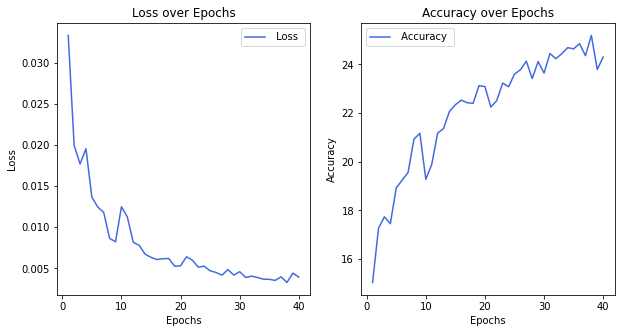

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 12. Modified Network5

max PSNR = 27.783  (40 epochs)

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}




In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(4, 0.714232)

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 40                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 20):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 6566.459 |	MSE loss: 25.751
Train epoch 0: [160/250 (62%)]	Loss: 129.268 |	MSE loss: 0.507
Test epoch 0: Average losses:	MSE loss: 0.246	Sequence-wise PSNR:  6.280

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 83.880 |	MSE loss: 0.329
Train epoch 1: [160/250 (62%)]	Loss: 23.576 |	MSE loss: 0.092
Test epoch 1: Average losses:	MSE loss: 0.077	Sequence-wise PSNR:  11.331

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 17.195 |	MSE loss: 0.067
Train epoch 2: [160/250 (62%)]	Loss: 13.395 |	MSE loss: 0.053
Test epoch 2: Average losses:	MSE loss: 0.035	Sequence-wise PSNR:  14.643

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 6.101 |	MSE loss: 0.024
Train epoch 3: [160/250 (62%)]	Loss: 5.081 |	MSE loss: 0.020
Test epoch 3: Average losses:	MSE loss: 0.025	Sequence-wise PSNR:  16.138

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 4.032 |	MSE loss: 0.016
Train epoch 4: [160/250 (62%)]	Loss: 5.323 |	MSE los

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
<class 'list'>
[tensor(0.2462, device='cuda:0'), tensor(0.0771, device='cuda:0'), tensor(0.0354, device='cuda:0'), tensor(0.0251, device='cuda:0'), tensor(0.0174, device='cuda:0'), tensor(0.0143, device='cuda:0'), tensor(0.0127, device='cuda:0'), tensor(0.0130, device='cuda:0'), tensor(0.0089, device='cuda:0'), tensor(0.0087, device='cuda:0'), tensor(0.0089, device='cuda:0'), tensor(0.0135, device='cuda:0'), tensor(0.0073, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0048, device='cuda:0'), tensor(0.0065, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(0.0048, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0031, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(0.0028, device='cuda:0'), tensor(

The max PSNR is:  27.783000946044922


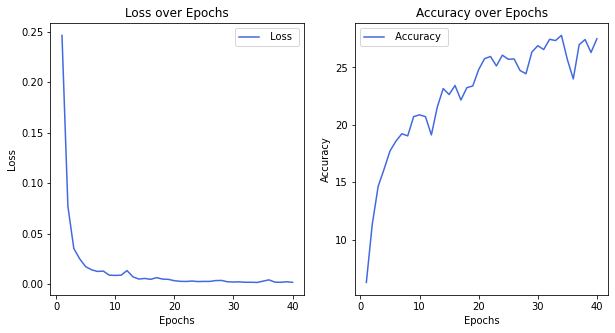

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 13. Hyper-parameter chosen based on Modified 5

max PSNR = 25.09  (40 epochs)

increase the batch size

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}




In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 40                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 32
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(4, 0.714232)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 20):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 6131.451 |	MSE loss: 24.045
Test epoch 0: Average losses:	MSE loss: 0.656	Sequence-wise PSNR:  2.062

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 163.553 |	MSE loss: 0.641
Test epoch 1: Average losses:	MSE loss: 0.237	Sequence-wise PSNR:  6.449

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 37.506 |	MSE loss: 0.147
Test epoch 2: Average losses:	MSE loss: 0.111	Sequence-wise PSNR:  9.713

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 22.876 |	MSE loss: 0.090
Test epoch 3: Average losses:	MSE loss: 0.062	Sequence-wise PSNR:  12.238

Learning rate: 0.001
Train epoch 4: [0/250 (0%)]	Loss: 12.503 |	MSE loss: 0.049
Test epoch 4: Average losses:	MSE loss: 0.051	Sequence-wise PSNR:  13.224

Learning rate: 0.001
Train epoch 5: [0/250 (0%)]	Loss: 13.285 |	MSE loss: 0.052
Test epoch 5: Average losses:	MSE loss: 0.036	Sequence-wise PSNR:  14.659

Learning rate: 0.001
Train epoch 6: [0/250 (0%)]	Loss: 9.569 |	MSE lo

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
<class 'list'>
[tensor(0.6561, device='cuda:0'), tensor(0.2365, device='cuda:0'), tensor(0.1113, device='cuda:0'), tensor(0.0624, device='cuda:0'), tensor(0.0506, device='cuda:0'), tensor(0.0357, device='cuda:0'), tensor(0.0234, device='cuda:0'), tensor(0.0274, device='cuda:0'), tensor(0.0216, device='cuda:0'), tensor(0.0182, device='cuda:0'), tensor(0.0143, device='cuda:0'), tensor(0.0141, device='cuda:0'), tensor(0.0115, device='cuda:0'), tensor(0.0151, device='cuda:0'), tensor(0.0268, device='cuda:0'), tensor(0.0201, device='cuda:0'), tensor(0.0097, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor(0.0069, device='cuda:0'), tensor(0.0092, device='cuda:0'), tensor(0.0076, device='cuda:0'), tensor(0.0065, device='cuda:0'), tensor(0.0065, device='cuda:0'), tensor(0.0063, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(

The max PSNR is:  25.098886489868164


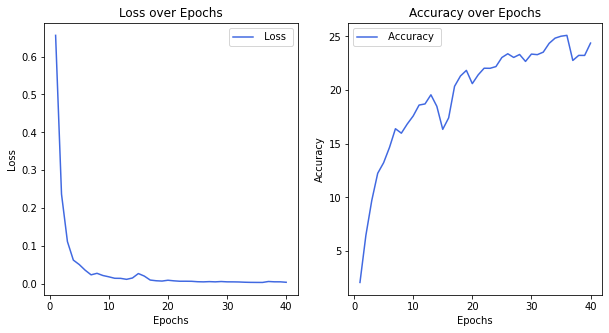

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 14. Modified Network 6

max PSNR = 32.511

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            nn.PReLU(),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 25):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 4533.988 |	MSE loss: 17.780
Train epoch 0: [80/250 (31%)]	Loss: 54.179 |	MSE loss: 0.212
Train epoch 0: [160/250 (62%)]	Loss: 28.698 |	MSE loss: 0.113
Train epoch 0: [240/250 (94%)]	Loss: 16.997 |	MSE loss: 0.067
Test epoch 0: Average losses:	MSE loss: 0.064	Sequence-wise PSNR:  12.132

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 26.665 |	MSE loss: 0.105
Train epoch 1: [80/250 (31%)]	Loss: 11.905 |	MSE loss: 0.047
Train epoch 1: [160/250 (62%)]	Loss: 5.729 |	MSE loss: 0.022
Train epoch 1: [240/250 (94%)]	Loss: 6.927 |	MSE loss: 0.027
Test epoch 1: Average losses:	MSE loss: 0.035	Sequence-wise PSNR:  14.971

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 9.441 |	MSE loss: 0.037
Train epoch 2: [80/250 (31%)]	Loss: 4.928 |	MSE loss: 0.019
Train epoch 2: [160/250 (62%)]	Loss: 4.340 |	MSE loss: 0.017
Train epoch 2: [240/250 (94%)]	Loss: 2.899 |	MSE loss: 0.011
Test epoch 2: Average losses:	MSE loss: 0.014	Sequence-wis

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 81))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
<class 'list'>
[tensor(0.0645, device='cuda:0'), tensor(0.0346, device='cuda:0'), tensor(0.0140, device='cuda:0'), tensor(0.0092, device='cuda:0'), tensor(0.0085, device='cuda:0'), tensor(0.0084, device='cuda:0'), tensor(0.0087, device='cuda:0'), tensor(0.0070, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(0.0060, device='cuda:0'), tensor(0.0046, device='cuda:0'), tensor(0.0109, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0036, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(0.0036, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(0.002

The max PSNR is:  32.511314392089844


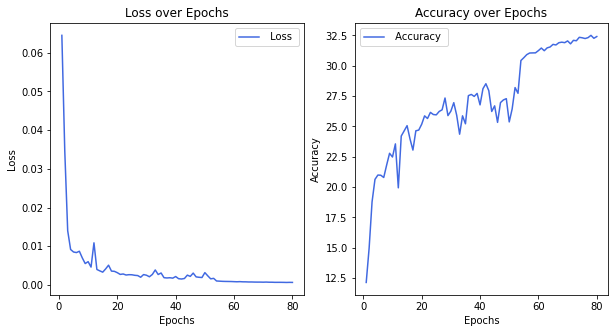

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## **15. Modified Network 7 (best performance**)

max PSNR 36.8200

In [ ]:
# Network setup
def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
# Parameters defined
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 45
M = 56

In [ ]:
# benchmark test
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(5, 0.703648)

In [ ]:
# training and testing
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 10563.006 |	MSE loss: 41.424
Train epoch 0: [80/250 (31%)]	Loss: 201.814 |	MSE loss: 0.791
Train epoch 0: [160/250 (62%)]	Loss: 36.228 |	MSE loss: 0.142
Train epoch 0: [240/250 (94%)]	Loss: 15.583 |	MSE loss: 0.061
Test epoch 0: Average losses:	MSE loss: 0.058	Sequence-wise PSNR:  12.490

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 12.035 |	MSE loss: 0.047
Train epoch 1: [80/250 (31%)]	Loss: 9.575 |	MSE loss: 0.038
Train epoch 1: [160/250 (62%)]	Loss: 7.261 |	MSE loss: 0.028
Train epoch 1: [240/250 (94%)]	Loss: 7.474 |	MSE loss: 0.029
Test epoch 1: Average losses:	MSE loss: 0.024	Sequence-wise PSNR:  16.326

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 7.595 |	MSE loss: 0.030
Train epoch 2: [80/250 (31%)]	Loss: 3.409 |	MSE loss: 0.013
Train epoch 2: [160/250 (62%)]	Loss: 4.571 |	MSE loss: 0.018
Train epoch 2: [240/250 (94%)]	Loss: 2.762 |	MSE loss: 0.011
Test epoch 2: Average losses:	MSE loss: 0.013	Sequence-wi

In [ ]:
# print the results
from matplotlib import pyplot as plt

xs = list(range(1, 101))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
<class 'list'>
[tensor(0.0582, device='cuda:0'), tensor(0.0243, device='cuda:0'), tensor(0.0134, device='cuda:0'), tensor(0.0115, device='cuda:0'), tensor(0.0076, device='cuda:0'), tensor(0.0200, device='cuda:0'), tensor(0.0050, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(0.0037, device='cuda:0'), tensor(0.0046, device='cuda:0'), tensor(0.0037, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.0025, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(0.0031, device='cuda:0'

The max PSNR is:  36.82001876831055


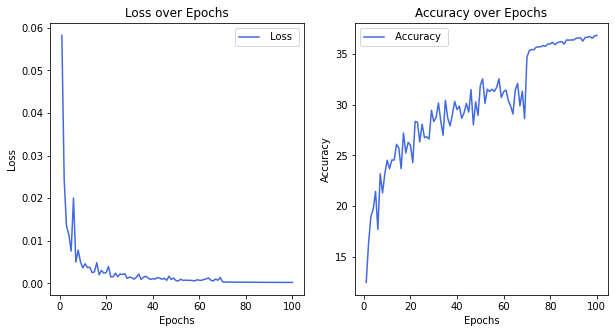

In [ ]:
# plot the curves
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The first PSNR is:  34.074818
The second PSNR is:  36.346317
The third PSNR is:  47.174095


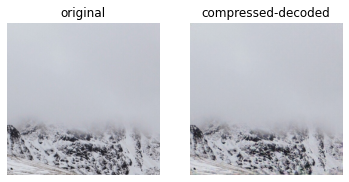

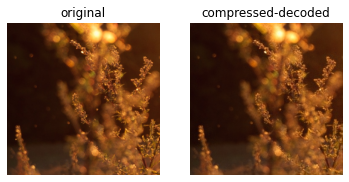

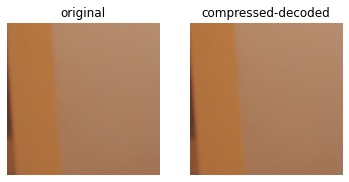

In [ ]:

# visualization for training set images (in Section27, we also visulize the test set images)
import matplotlib.pyplot as plt

image0 = train_dataset[0].unsqueeze(0).to(device)
image1 = train_dataset[1].unsqueeze(0).to(device)
image2 = train_dataset[2].unsqueeze(0).to(device)

net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted0 = net(image0)['x_hat'].squeeze(0).detach()
predicted1 = net(image1)['x_hat'].squeeze(0).detach()
predicted2 = net(image2)['x_hat'].squeeze(0).detach()

fig1, axes = plt.subplots(1,2)
axes[0].imshow(image0.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted0.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr = PSNR(image0,predicted0).cpu().numpy()
print("The first PSNR is: ",mypsnr)

fig2, axes = plt.subplots(1,2)
axes[0].imshow(image1.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted1.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr2 = PSNR(image1,predicted1).cpu().numpy()
print("The second PSNR is: ",mypsnr2)


fig3, axes = plt.subplots(1,2)
axes[0].imshow(image2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted2.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr3 = PSNR(image2,predicted2).cpu().numpy()
print("The third PSNR is: ",mypsnr3)

## 16. Modified Network7 hyper-parameter 1

max PSNR 36.8047

In [ ]:


def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 2e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 45
M = 56

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.002
Train epoch 0: [0/250 (0%)]	Loss: 10563.006 |	MSE loss: 41.424
Train epoch 0: [80/250 (31%)]	Loss: 321.030 |	MSE loss: 1.259
Train epoch 0: [160/250 (62%)]	Loss: 52.002 |	MSE loss: 0.204
Train epoch 0: [240/250 (94%)]	Loss: 32.961 |	MSE loss: 0.129
Test epoch 0: Average losses:	MSE loss: 0.083	Sequence-wise PSNR:  11.017

Learning rate: 0.002
Train epoch 1: [0/250 (0%)]	Loss: 23.085 |	MSE loss: 0.091
Train epoch 1: [80/250 (31%)]	Loss: 12.895 |	MSE loss: 0.051
Train epoch 1: [160/250 (62%)]	Loss: 13.594 |	MSE loss: 0.053
Train epoch 1: [240/250 (94%)]	Loss: 11.038 |	MSE loss: 0.043
Test epoch 1: Average losses:	MSE loss: 0.036	Sequence-wise PSNR:  14.723

Learning rate: 0.002
Train epoch 2: [0/250 (0%)]	Loss: 17.838 |	MSE loss: 0.070
Train epoch 2: [80/250 (31%)]	Loss: 5.562 |	MSE loss: 0.022
Train epoch 2: [160/250 (62%)]	Loss: 8.519 |	MSE loss: 0.033
Train epoch 2: [240/250 (94%)]	Loss: 3.702 |	MSE loss: 0.015
Test epoch 2: Average losses:	MSE loss: 0.026	Sequenc

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 101))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
<class 'list'>
[tensor(0.0835, device='cuda:0'), tensor(0.0365, device='cuda:0'), tensor(0.0265, device='cuda:0'), tensor(0.0275, device='cuda:0'), tensor(0.0187, device='cuda:0'), tensor(0.0108, device='cuda:0'), tensor(0.0137, device='cuda:0'), tensor(0.0111, device='cuda:0'), tensor(0.0102, device='cuda:0'), tensor(0.0063, device='cuda:0'), tensor(0.0069, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(0.0059, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.0035, device='cuda:0'

The max PSNR is:  36.80473709106445


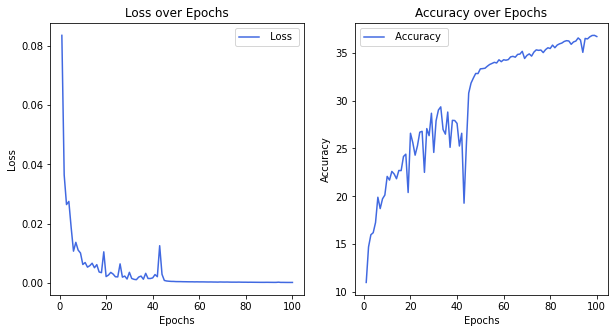

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 17. Modified Network 7 (data augmentation)
max PSNR 36.1599

In [ ]:


def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 45
M = 56

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(5, 0.703648)

In [ ]:


torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.RandomHorizontalFlip(p = 0.5),  transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 9401.422 |	MSE loss: 36.868
Train epoch 0: [80/250 (31%)]	Loss: 170.291 |	MSE loss: 0.668
Train epoch 0: [160/250 (62%)]	Loss: 27.423 |	MSE loss: 0.108
Train epoch 0: [240/250 (94%)]	Loss: 9.122 |	MSE loss: 0.036
Test epoch 0: Average losses:	MSE loss: 0.071	Sequence-wise PSNR:  11.682

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 19.279 |	MSE loss: 0.076
Train epoch 1: [80/250 (31%)]	Loss: 11.831 |	MSE loss: 0.046
Train epoch 1: [160/250 (62%)]	Loss: 4.378 |	MSE loss: 0.017
Train epoch 1: [240/250 (94%)]	Loss: 6.873 |	MSE loss: 0.027
Test epoch 1: Average losses:	MSE loss: 0.020	Sequence-wise PSNR:  17.229

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 4.270 |	MSE loss: 0.017
Train epoch 2: [80/250 (31%)]	Loss: 4.028 |	MSE loss: 0.016
Train epoch 2: [160/250 (62%)]	Loss: 3.343 |	MSE loss: 0.013
Train epoch 2: [240/250 (94%)]	Loss: 3.397 |	MSE loss: 0.013
Test epoch 2: Average losses:	MSE loss: 0.012	Sequence-wis

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 88))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
<class 'list'>
[tensor(0.0715, device='cuda:0'), tensor(0.0197, device='cuda:0'), tensor(0.0124, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(0.0079, device='cuda:0'), tensor(0.0113, device='cuda:0'), tensor(0.0089, device='cuda:0'), tensor(0.0063, device='cuda:0'), tensor(0.0042, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(0.0070, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0029, de

The max PSNR is:  36.15992736816406


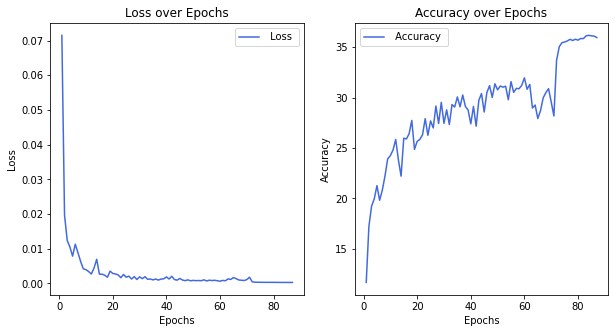

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 18. Modified Network7 (bottleneck)

max PSNR = 36.136

In [ ]:


def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            nn.ConvTranspose2d(N, N, kernel_size=1),
            deconv(N, N),
            nn.ConvTranspose2d(N, N, kernel_size=1),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 45
M = 56

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(6, 0.703648)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 17596.736 |	MSE loss: 69.007
Train epoch 0: [80/250 (31%)]	Loss: 654.230 |	MSE loss: 2.566
Train epoch 0: [160/250 (62%)]	Loss: 171.285 |	MSE loss: 0.672
Train epoch 0: [240/250 (94%)]	Loss: 54.178 |	MSE loss: 0.212
Test epoch 0: Average losses:	MSE loss: 0.171	Sequence-wise PSNR:  7.828

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 58.662 |	MSE loss: 0.230
Train epoch 1: [80/250 (31%)]	Loss: 14.285 |	MSE loss: 0.056
Train epoch 1: [160/250 (62%)]	Loss: 53.949 |	MSE loss: 0.212
Train epoch 1: [240/250 (94%)]	Loss: 14.812 |	MSE loss: 0.058
Test epoch 1: Average losses:	MSE loss: 0.070	Sequence-wise PSNR:  11.979

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 23.820 |	MSE loss: 0.093
Train epoch 2: [80/250 (31%)]	Loss: 4.477 |	MSE loss: 0.018
Train epoch 2: [160/250 (62%)]	Loss: 10.019 |	MSE loss: 0.039
Train epoch 2: [240/250 (94%)]	Loss: 4.685 |	MSE loss: 0.018
Test epoch 2: Average losses:	MSE loss: 0.053	Sequen

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 96))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
<class 'list'>
[tensor(0.1707, device='cuda:0'), tensor(0.0695, device='cuda:0'), tensor(0.0527, device='cuda:0'), tensor(0.0119, device='cuda:0'), tensor(0.0100, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(0.0061, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(0.0050, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0030, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(0.0024, dev

The max PSNR is:  36.13688278198242


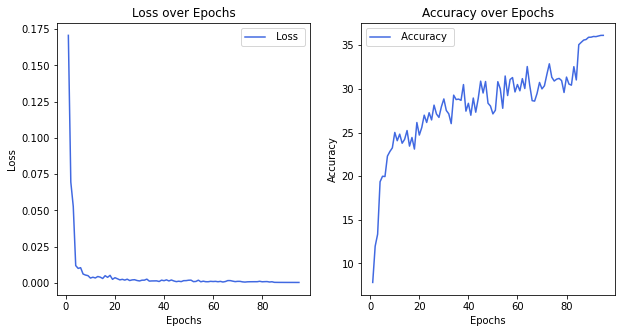

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 19. Selections

max PSNR = 35.488

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(4, 0.714232)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 25):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 6058.695 |	MSE loss: 23.760
Train epoch 0: [80/250 (31%)]	Loss: 88.640 |	MSE loss: 0.348
Train epoch 0: [160/250 (62%)]	Loss: 60.565 |	MSE loss: 0.238
Train epoch 0: [240/250 (94%)]	Loss: 18.130 |	MSE loss: 0.071
Test epoch 0: Average losses:	MSE loss: 0.086	Sequence-wise PSNR:  10.804

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 35.894 |	MSE loss: 0.141
Train epoch 1: [80/250 (31%)]	Loss: 22.188 |	MSE loss: 0.087
Train epoch 1: [160/250 (62%)]	Loss: 7.108 |	MSE loss: 0.028
Train epoch 1: [240/250 (94%)]	Loss: 11.201 |	MSE loss: 0.044
Test epoch 1: Average losses:	MSE loss: 0.042	Sequence-wise PSNR:  14.256

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 13.422 |	MSE loss: 0.053
Train epoch 2: [80/250 (31%)]	Loss: 8.567 |	MSE loss: 0.034
Train epoch 2: [160/250 (62%)]	Loss: 5.159 |	MSE loss: 0.020
Train epoch 2: [240/250 (94%)]	Loss: 6.702 |	MSE loss: 0.026
Test epoch 2: Average losses:	MSE loss: 0.019	Sequence-w

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 83))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
<class 'list'>
[tensor(0.0855, device='cuda:0'), tensor(0.0420, device='cuda:0'), tensor(0.0193, device='cuda:0'), tensor(0.0136, device='cuda:0'), tensor(0.0074, device='cuda:0'), tensor(0.0114, device='cuda:0'), tensor(0.0077, device='cuda:0'), tensor(0.0064, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(0.0059, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(0.0031, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0028, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.0029, device='cuda:0'), tens

The max PSNR is:  35.488101959228516


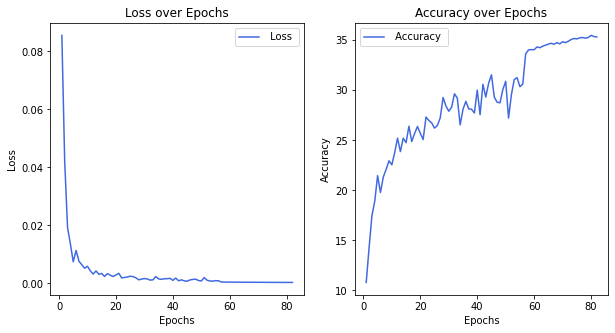

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The first PSNR is:  27.006271
The second PSNR is:  32.104828
The third PSNR is:  45.34525


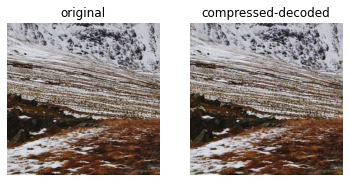

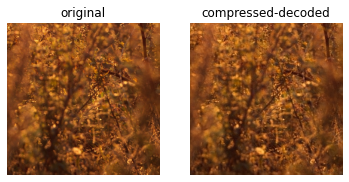

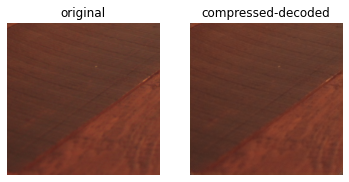

In [ ]:

# visualization
import matplotlib.pyplot as plt

image0 = train_dataset[0].unsqueeze(0).to(device)
image1 = train_dataset[1].unsqueeze(0).to(device)
image2 = train_dataset[2].unsqueeze(0).to(device)

net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted0 = net(image0)['x_hat'].squeeze(0).detach()
predicted1 = net(image1)['x_hat'].squeeze(0).detach()
predicted2 = net(image2)['x_hat'].squeeze(0).detach()

fig1, axes = plt.subplots(1,2)
axes[0].imshow(image0.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted0.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr = PSNR(image0,predicted0).cpu().numpy()
print("The first PSNR is: ",mypsnr)

fig2, axes = plt.subplots(1,2)
axes[0].imshow(image1.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted1.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr2 = PSNR(image1,predicted1).cpu().numpy()
print("The second PSNR is: ",mypsnr2)


fig3, axes = plt.subplots(1,2)
axes[0].imshow(image2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted2.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr3 = PSNR(image2,predicted2).cpu().numpy()
print("The third PSNR is: ",mypsnr3)

## 20. Selections modified1 (increase epochs)
max PSNR = 35.854

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(4, 0.714232)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 6058.695 |	MSE loss: 23.760
Train epoch 0: [80/250 (31%)]	Loss: 88.640 |	MSE loss: 0.348
Train epoch 0: [160/250 (62%)]	Loss: 60.566 |	MSE loss: 0.238
Train epoch 0: [240/250 (94%)]	Loss: 18.129 |	MSE loss: 0.071
Test epoch 0: Average losses:	MSE loss: 0.086	Sequence-wise PSNR:  10.804

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 35.894 |	MSE loss: 0.141
Train epoch 1: [80/250 (31%)]	Loss: 22.187 |	MSE loss: 0.087
Train epoch 1: [160/250 (62%)]	Loss: 7.104 |	MSE loss: 0.028
Train epoch 1: [240/250 (94%)]	Loss: 11.262 |	MSE loss: 0.044
Test epoch 1: Average losses:	MSE loss: 0.042	Sequence-wise PSNR:  14.246

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 13.471 |	MSE loss: 0.053
Train epoch 2: [80/250 (31%)]	Loss: 8.149 |	MSE loss: 0.032
Train epoch 2: [160/250 (62%)]	Loss: 6.739 |	MSE loss: 0.026
Train epoch 2: [240/250 (94%)]	Loss: 4.898 |	MSE loss: 0.019
Test epoch 2: Average losses:	MSE loss: 0.015	Sequence-w

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 100))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
<class 'list'>
[tensor(0.0855, device='cuda:0'), tensor(0.0421, device='cuda:0'), tensor(0.0153, device='cuda:0'), tensor(0.0113, device='cuda:0'), tensor(0.0080, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(0.0037, device='cuda:0'), tensor(0.0030, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(0.0024, device='cuda:0'), te

The max PSNR is:  35.85466003417969


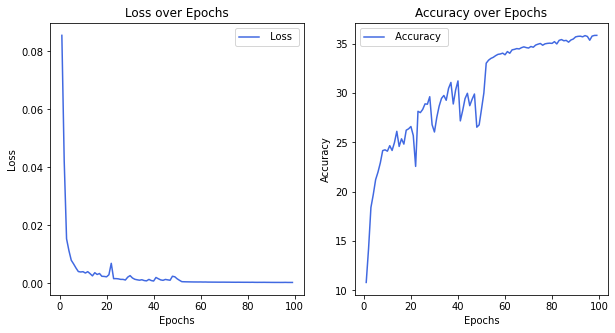

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The first PSNR is:  31.572083
The second PSNR is:  37.062405
The third PSNR is:  43.748337


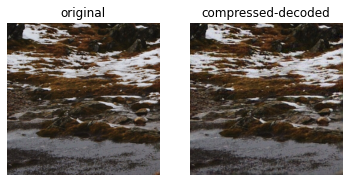

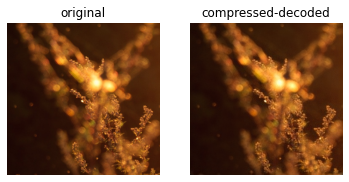

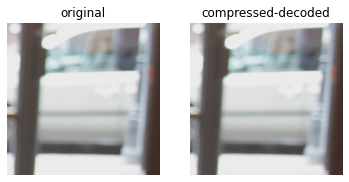

In [ ]:

# visualization
import matplotlib.pyplot as plt

image0 = train_dataset[0].unsqueeze(0).to(device)
image1 = train_dataset[1].unsqueeze(0).to(device)
image2 = train_dataset[2].unsqueeze(0).to(device)

net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted0 = net(image0)['x_hat'].squeeze(0).detach()
predicted1 = net(image1)['x_hat'].squeeze(0).detach()
predicted2 = net(image2)['x_hat'].squeeze(0).detach()

fig1, axes = plt.subplots(1,2)
axes[0].imshow(image0.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted0.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr = PSNR(image0,predicted0).cpu().numpy()
print("The first PSNR is: ",mypsnr)

fig2, axes = plt.subplots(1,2)
axes[0].imshow(image1.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted1.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr2 = PSNR(image1,predicted1).cpu().numpy()
print("The second PSNR is: ",mypsnr2)


fig3, axes = plt.subplots(1,2)
axes[0].imshow(image2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted2.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr3 = PSNR(image2,predicted2).cpu().numpy()
print("The third PSNR is: ",mypsnr3)

## 21. Selections modified 2
max PSNR = 28.833

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(4, 0.714232)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.0001
Train epoch 0: [0/250 (0%)]	Loss: 6058.695 |	MSE loss: 23.760
Train epoch 0: [80/250 (31%)]	Loss: 479.415 |	MSE loss: 1.880
Train epoch 0: [160/250 (62%)]	Loss: 221.252 |	MSE loss: 0.868
Train epoch 0: [240/250 (94%)]	Loss: 123.029 |	MSE loss: 0.482
Test epoch 0: Average losses:	MSE loss: 0.540	Sequence-wise PSNR:  2.874

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 170.576 |	MSE loss: 0.669
Train epoch 1: [80/250 (31%)]	Loss: 104.203 |	MSE loss: 0.409
Train epoch 1: [160/250 (62%)]	Loss: 46.840 |	MSE loss: 0.184
Train epoch 1: [240/250 (94%)]	Loss: 27.237 |	MSE loss: 0.107
Test epoch 1: Average losses:	MSE loss: 0.188	Sequence-wise PSNR:  7.474

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 28.061 |	MSE loss: 0.110
Train epoch 2: [80/250 (31%)]	Loss: 33.596 |	MSE loss: 0.132
Train epoch 2: [160/250 (62%)]	Loss: 19.922 |	MSE loss: 0.078
Train epoch 2: [240/250 (94%)]	Loss: 18.169 |	MSE loss: 0.071
Test epoch 2: Average losses:	MSE loss: 0.104	

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 99))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
<class 'list'>
[tensor(0.5399, device='cuda:0'), tensor(0.1881, device='cuda:0'), tensor(0.1040, device='cuda:0'), tensor(0.0652, device='cuda:0'), tensor(0.0442, device='cuda:0'), tensor(0.0349, device='cuda:0'), tensor(0.0276, device='cuda:0'), tensor(0.0222, device='cuda:0'), tensor(0.0189, device='cuda:0'), tensor(0.0166, device='cuda:0'), tensor(0.0142, device='cuda:0'), tensor(0.0121, device='cuda:0'), tensor(0.0119, device='cuda:0'), tensor(0.0104, device='cuda:0'), tensor(0.0095, device='cuda:0'), tensor(0.0093, device='cuda:0'), tensor(0.0086, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor

The max PSNR is:  28.83305549621582


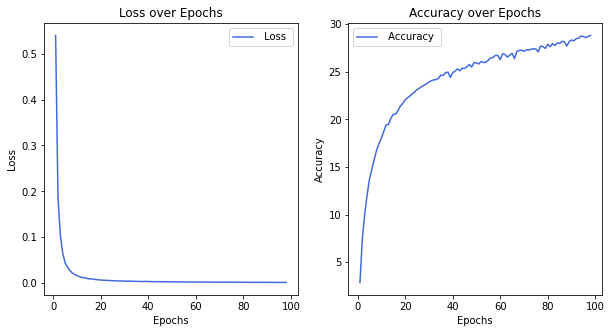

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 22. Selection modified 3
max PSNR = 34.796

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 0.5e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.0005
Train epoch 0: [0/250 (0%)]	Loss: 6058.695 |	MSE loss: 23.760
Train epoch 0: [80/250 (31%)]	Loss: 114.009 |	MSE loss: 0.447
Train epoch 0: [160/250 (62%)]	Loss: 76.746 |	MSE loss: 0.301
Train epoch 0: [240/250 (94%)]	Loss: 22.347 |	MSE loss: 0.088
Test epoch 0: Average losses:	MSE loss: 0.120	Sequence-wise PSNR:  9.398

Learning rate: 0.0005
Train epoch 1: [0/250 (0%)]	Loss: 49.715 |	MSE loss: 0.195
Train epoch 1: [80/250 (31%)]	Loss: 26.362 |	MSE loss: 0.103
Train epoch 1: [160/250 (62%)]	Loss: 10.548 |	MSE loss: 0.041
Train epoch 1: [240/250 (94%)]	Loss: 6.139 |	MSE loss: 0.024
Test epoch 1: Average losses:	MSE loss: 0.039	Sequence-wise PSNR:  14.230

Learning rate: 0.0005
Train epoch 2: [0/250 (0%)]	Loss: 7.571 |	MSE loss: 0.030
Train epoch 2: [80/250 (31%)]	Loss: 7.183 |	MSE loss: 0.028
Train epoch 2: [160/250 (62%)]	Loss: 5.355 |	MSE loss: 0.021
Train epoch 2: [240/250 (94%)]	Loss: 3.609 |	MSE loss: 0.014
Test epoch 2: Average losses:	MSE loss: 0.020	Sequence

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 100))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
<class 'list'>
[tensor(0.1203, device='cuda:0'), tensor(0.0395, device='cuda:0'), tensor(0.0200, device='cuda:0'), tensor(0.0125, device='cuda:0'), tensor(0.0110, device='cuda:0'), tensor(0.0083, device='cuda:0'), tensor(0.0073, device='cuda:0'), tensor(0.0060, device='cuda:0'), tensor(0.0056, device='cuda:0'), tensor(0.0058, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(0.0034, device='cuda:0'), te

The max PSNR is:  34.79628372192383


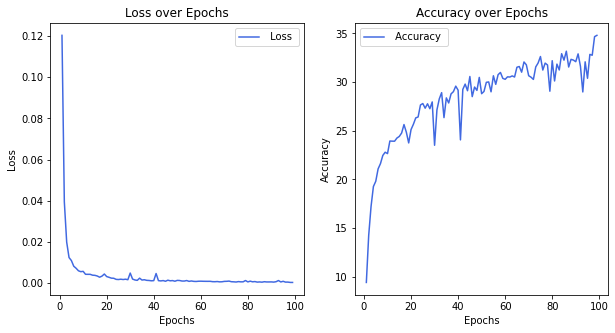

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

## 23. Selection modified 4

max PSNR = 28.079

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 2e-3  
batch_size = 16
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.002
Train epoch 0: [0/250 (0%)]	Loss: 6566.459 |	MSE loss: 25.751
Train epoch 0: [160/250 (62%)]	Loss: 136.725 |	MSE loss: 0.536
Test epoch 0: Average losses:	MSE loss: 0.227	Sequence-wise PSNR:  6.652

Learning rate: 0.002
Train epoch 1: [0/250 (0%)]	Loss: 81.607 |	MSE loss: 0.320
Train epoch 1: [160/250 (62%)]	Loss: 21.626 |	MSE loss: 0.085
Test epoch 1: Average losses:	MSE loss: 0.058	Sequence-wise PSNR:  12.427

Learning rate: 0.002
Train epoch 2: [0/250 (0%)]	Loss: 14.289 |	MSE loss: 0.056
Train epoch 2: [160/250 (62%)]	Loss: 23.985 |	MSE loss: 0.094
Test epoch 2: Average losses:	MSE loss: 0.041	Sequence-wise PSNR:  14.110

Learning rate: 0.002
Train epoch 3: [0/250 (0%)]	Loss: 8.913 |	MSE loss: 0.035
Train epoch 3: [160/250 (62%)]	Loss: 10.073 |	MSE loss: 0.040
Test epoch 3: Average losses:	MSE loss: 0.041	Sequence-wise PSNR:  14.570

Learning rate: 0.002
Train epoch 4: [0/250 (0%)]	Loss: 11.582 |	MSE loss: 0.045
Train epoch 4: [160/250 (62%)]	Loss: 7.055 |	MSE l

## 24. Selection modified 5

max PSNR = 26.031

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 2e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 40
M = 54

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(4, 0.714232)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.002
Train epoch 0: [0/250 (0%)]	Loss: 6058.695 |	MSE loss: 23.760
Train epoch 0: [80/250 (31%)]	Loss: 134.332 |	MSE loss: 0.527
Train epoch 0: [160/250 (62%)]	Loss: 63.209 |	MSE loss: 0.248
Train epoch 0: [240/250 (94%)]	Loss: 37.717 |	MSE loss: 0.148
Test epoch 0: Average losses:	MSE loss: 0.191	Sequence-wise PSNR:  7.711

Learning rate: 0.002
Train epoch 1: [0/250 (0%)]	Loss: 69.066 |	MSE loss: 0.271
Train epoch 1: [80/250 (31%)]	Loss: 34.652 |	MSE loss: 0.136
Train epoch 1: [160/250 (62%)]	Loss: 8.960 |	MSE loss: 0.035
Train epoch 1: [240/250 (94%)]	Loss: 15.545 |	MSE loss: 0.061
Test epoch 1: Average losses:	MSE loss: 0.042	Sequence-wise PSNR:  14.081

Learning rate: 0.002
Train epoch 2: [0/250 (0%)]	Loss: 25.484 |	MSE loss: 0.100
Train epoch 2: [80/250 (31%)]	Loss: 11.659 |	MSE loss: 0.046
Train epoch 2: [160/250 (62%)]	Loss: 9.099 |	MSE loss: 0.036
Train epoch 2: [240/250 (94%)]	Loss: 7.650 |	MSE loss: 0.030
Test epoch 2: Average losses:	MSE loss: 0.030	Sequence-

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 91))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
<class 'list'>
[tensor(0.1909, device='cuda:0'), tensor(0.0425, device='cuda:0'), tensor(0.0298, device='cuda:0'), tensor(0.0454, device='cuda:0'), tensor(0.0114, device='cuda:0'), tensor(0.0114, device='cuda:0'), tensor(0.0142, device='cuda:0'), tensor(0.0064, device='cuda:0'), tensor(0.0099, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(0.0042, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(0.0058, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0045, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.0036, device='cuda:0'), tensor(0.0032, device='cuda:0'), tenso

The max PSNR is:  36.031837463378906


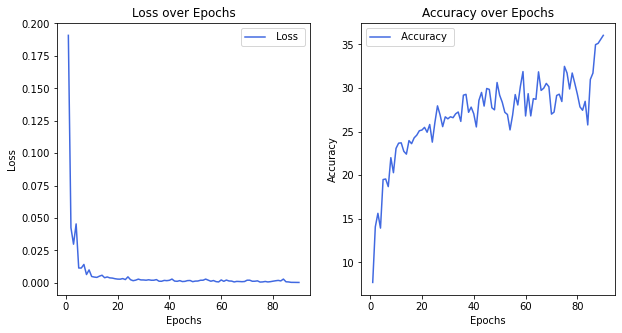

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The first PSNR is:  45.373016
The second PSNR is:  34.421173
The third PSNR is:  41.073093


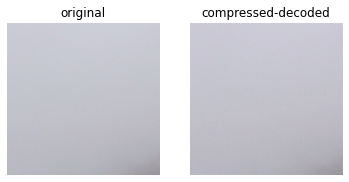

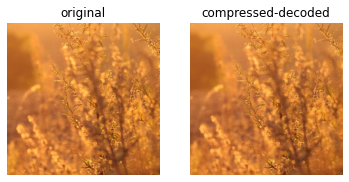

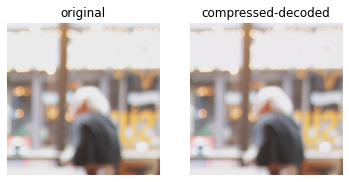

In [ ]:

# visualization
import matplotlib.pyplot as plt

image0 = train_dataset[0].unsqueeze(0).to(device)
image1 = train_dataset[1].unsqueeze(0).to(device)
image2 = train_dataset[2].unsqueeze(0).to(device)

net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted0 = net(image0)['x_hat'].squeeze(0).detach()
predicted1 = net(image1)['x_hat'].squeeze(0).detach()
predicted2 = net(image2)['x_hat'].squeeze(0).detach()

fig1, axes = plt.subplots(1,2)
axes[0].imshow(image0.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted0.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr = PSNR(image0,predicted0).cpu().numpy()
print("The first PSNR is: ",mypsnr)

fig2, axes = plt.subplots(1,2)
axes[0].imshow(image1.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted1.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr2 = PSNR(image1,predicted1).cpu().numpy()
print("The second PSNR is: ",mypsnr2)


fig3, axes = plt.subplots(1,2)
axes[0].imshow(image2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted2.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr3 = PSNR(image2,predicted2).cpu().numpy()
print("The third PSNR is: ",mypsnr3)

## 25. Modified 8
max PSNR = 26.67

In [ ]:

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
            nn.PReLU(),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 45
M = 56

In [ ]:
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)
benchmark(net)

# net = Model()
# net = net.to(device)
# benchmark(net)

##############################
[Acceptable Model Complexity]
##############################


##############################
[Acceptable Compression Ratio]
##############################
you can move on :)


(5, 0.703648)

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N,M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch

train_time = AverageMeter()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    epoch_train_start = time.time()
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    epoch_train_end = time.time()
    train_time.update(epoch_train_end - epoch_train_start)
    loss,psnr= test_epoch(epoch, test_dataset, test_transforms, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    PSNR_epoch.append(psnr)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
    if (train_time.sum/60 > 28):
      print("Time Up")
      break
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

Learning rate: 0.001
Train epoch 0: [0/250 (0%)]	Loss: 6877.998 |	MSE loss: 26.973
Train epoch 0: [80/250 (31%)]	Loss: 46.865 |	MSE loss: 0.184
Train epoch 0: [160/250 (62%)]	Loss: 17.090 |	MSE loss: 0.067
Train epoch 0: [240/250 (94%)]	Loss: 8.351 |	MSE loss: 0.033
Test epoch 0: Average losses:	MSE loss: 0.030	Sequence-wise PSNR:  15.450

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 9.083 |	MSE loss: 0.036
Train epoch 1: [80/250 (31%)]	Loss: 6.363 |	MSE loss: 0.025
Train epoch 1: [160/250 (62%)]	Loss: 5.641 |	MSE loss: 0.022
Train epoch 1: [240/250 (94%)]	Loss: 6.263 |	MSE loss: 0.025
Test epoch 1: Average losses:	MSE loss: 0.041	Sequence-wise PSNR:  14.407

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 17.564 |	MSE loss: 0.069
Train epoch 2: [80/250 (31%)]	Loss: 2.732 |	MSE loss: 0.011
Train epoch 2: [160/250 (62%)]	Loss: 4.502 |	MSE loss: 0.018
Train epoch 2: [240/250 (94%)]	Loss: 2.638 |	MSE loss: 0.010
Test epoch 2: Average losses:	MSE loss: 0.014	Sequence-wise 

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, 89))
ys = loss_epoch
ys1 = PSNR_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))
print(ys1)
print(type(ys1))

myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

myys1 = ys1.copy()
for i in range(0,len(myys1)):
  myys1[i] = myys1[i].cpu().item()
print(myys1)
print(type(myys1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
<class 'list'>
[tensor(0.0296, device='cuda:0'), tensor(0.0409, device='cuda:0'), tensor(0.0144, device='cuda:0'), tensor(0.0118, device='cuda:0'), tensor(0.0106, device='cuda:0'), tensor(0.0184, device='cuda:0'), tensor(0.0119, device='cuda:0'), tensor(0.0073, device='cuda:0'), tensor(0.0095, device='cuda:0'), tensor(0.0115, device='cuda:0'), tensor(0.0109, device='cuda:0'), tensor(0.0073, device='cuda:0'), tensor(0.0063, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(0.0057, device='cuda:0'), tensor(0.0046, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0043

The max PSNR is:  27.8641357421875


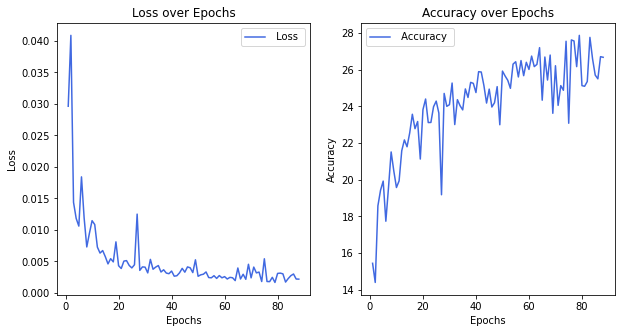

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# functions to show the loss

plt.title('Loss over Epochs')
plt.plot(xs,myys,'-',color = 'royalblue')
plt.legend([' Loss '])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# functions to show the accuracy
plt.subplot(1,2,2)
plt.title('Accuracy over Epochs')
plt.plot(xs,myys1,'-',color = 'royalblue')
plt.legend([' Accuracy '])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


print("The max PSNR is: ",max(myys1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The first PSNR is:  30.133532
The second PSNR is:  28.068342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The third PSNR is:  30.174015


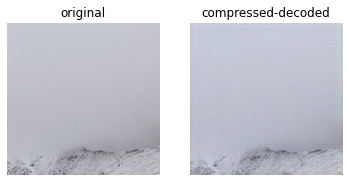

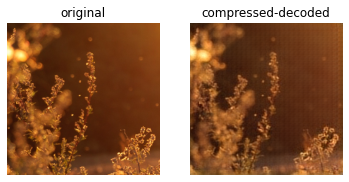

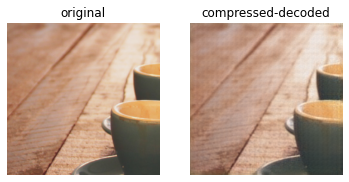

In [ ]:

# visualization
import matplotlib.pyplot as plt

image0 = train_dataset[0].unsqueeze(0).to(device)
image1 = train_dataset[1].unsqueeze(0).to(device)
image2 = train_dataset[2].unsqueeze(0).to(device)

net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted0 = net(image0)['x_hat'].squeeze(0).detach()
predicted1 = net(image1)['x_hat'].squeeze(0).detach()
predicted2 = net(image2)['x_hat'].squeeze(0).detach()

fig1, axes = plt.subplots(1,2)
axes[0].imshow(image0.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted0.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr = PSNR(image0,predicted0).cpu().numpy()
print("The first PSNR is: ",mypsnr)

fig2, axes = plt.subplots(1,2)
axes[0].imshow(image1.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted1.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr2 = PSNR(image1,predicted1).cpu().numpy()
print("The second PSNR is: ",mypsnr2)


fig3, axes = plt.subplots(1,2)
axes[0].imshow(image2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted2.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr3 = PSNR(image2,predicted2).cpu().numpy()
print("The third PSNR is: ",mypsnr3)

## 26. Parameter-needed Test for each layer

Calculate the ouput size after each layer, the paramters needed for the find deconvolution layer to reconstruct the images into their original sizes (3x255x255)

In [ ]:
import torch
import torch.nn as nn
input=torch.randn(1, 3, 256, 256)


a1 = nn.Conv2d(3, 32, kernel_size=11, stride=3, padding=1)
a2 = nn.PReLU()
a3 = nn.Conv2d(32, 16, kernel_size=1)
a4 = nn.PReLU()
a5 = nn.Conv2d(16, 16, kernel_size=9, stride=2, padding=1)
a6 = nn.PReLU()
a7 = nn.Conv2d(16, 32, kernel_size=1)
a8 = nn.PReLU()


output = a1(input)
output = a2(output)
output = a3(output)
output = a4(output)
output = a5(output)
output = a6(output)
output = a7(output)
output = a8(output)

print(output.size())

# b1 = nn.ConvTranspose2d(64, 32, kernel_size=11, stride=3, padding=2, output_padding=2)
# output1 = b1(output)
# b2 = nn.ConvTranspose2d(32, 3, kernel_size=11, stride=3, padding=3, output_padding=2)
# output2 = b2(output1)
b2 = nn.ConvTranspose2d(32, 16, kernel_size=11, stride=2, padding=1)
output2 = b2(output)

b3 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=3, padding=1, output_padding=1)
output3 = b3(output2)

# print(output1.size())
print(output2.size())
print(output3.size())

a1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding = 1)


torch.Size([1, 32, 39, 39])
torch.Size([1, 16, 85, 85])
torch.Size([1, 3, 256, 256])


### modified 7

In [ ]:
import torch
import torch.nn as nn
input=torch.randn(1, 3, 256, 256)

a1 = conv(3, N)
a2 = nn.Conv2d(N, N-2,kernel_size=1)
a3 = conv(N-2, N-2)
a4 = nn.Conv2d(N-2, N,kernel_size=1)
a5 = conv(N, M)

output = a1(input)
output = a2(output)
output = a3(output)
output = a4(output)
output = a5(output)

b1 = deconv(M,N)
b2 = nn.ConvTranspose2d(N, N, kernel_size = 1)
b3 = deconv(N,N)
b4 = nn.ConvTranspose2d(N, N, kernel_size = 1)
b5 = nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2,padding = 1,output_padding=1)
output1 = b1(output)
output1 = b2(output1)
output1 = b3(output1)
output1 = b4(output1)
output2 = b5(output1)

print(output.size())
print(output1.size())
print(output2.size())

torch.Size([1, 56, 32, 32])
torch.Size([1, 45, 128, 128])
torch.Size([1, 3, 256, 256])


In [ ]:
1 - (54*32*32)/(3*256*256)

0.71875

## 27. Result test for the best performance network (Modified 7) (no need for training)

Loading the checkpoint and visulize the results for original images with their decoded images

In [ ]:
# network structure define
def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self,N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            # nn.PReLU(),
            # nn.Conv2d(40, 40, kernel_size=1),
            nn.Conv2d(N, N, kernel_size=1),
            conv(N, N),
            nn.Conv2d(N, N, kernel_size=1),
            # nn.PReLU(),
            conv(N, M),
        )


        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            nn.ConvTranspose2d(N, 3, kernel_size=3, stride=2, padding = 1, output_padding=1),

        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}



In [ ]:
# parameters define
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
image_dataset = '/content/drive/MyDrive/ELEC5306-2022/Image'  # path to the root of the image dataset
sequence_dataset = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the video dataset
checkpoint = ''                                   # load pretrained model
epochs = 100                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 2e-3  
batch_size = 8
test_batch_size = 16 
num_workers = 2                         # multi-process for loading training data 
N = 45
M = 56

In [ ]:
# data preparation
train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(image_dataset, transform=train_transforms)
test_dataset = SequenceFolder(sequence_dataset, split="test", transform=None)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

In [ ]:
print(type(test_dataset[0]))
print(type(train_dataset[0]))

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>


In [ ]:
# change the type of images in the test set to tensors
import torch
from torchvision import transforms
transform1 = transforms.Compose([
	transforms.CenterCrop((256,256)), 
	transforms.ToTensor(), 
	]
)
img_PIL_Tensor_0 = transform1(test_dataset[0])
img_PIL_Tensor_1 = transform1(test_dataset[100])
img_PIL_Tensor_2 = transform1(test_dataset[200])
print(type(img_PIL_Tensor_0))

<class 'torch.Tensor'>


In [ ]:
# load network into GPU
device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
net = Network(N,M)
net = net.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The first PSNR is:  38.399895
The second PSNR is:  39.907692
The third PSNR is:  38.39649


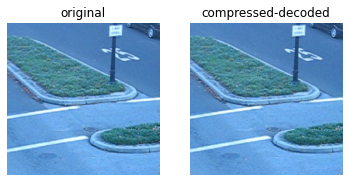

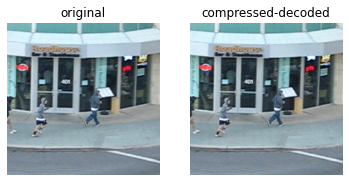

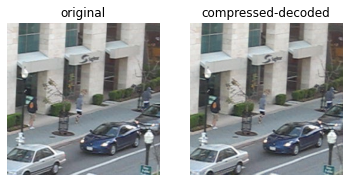

In [ ]:

# visualization
import matplotlib.pyplot as plt

## Visulize training set
# image0 = train_dataset[0].unsqueeze(0).to(device)
# image1 = train_dataset[1].unsqueeze(0).to(device)
# image2 = train_dataset[2].unsqueeze(0).to(device)

## Visulize test set
image0 = img_PIL_Tensor_0.unsqueeze(0).to(device)
image1 = img_PIL_Tensor_1.unsqueeze(0).to(device)
image2 = img_PIL_Tensor_2.unsqueeze(0).to(device)

net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted0 = net(image0)['x_hat'].squeeze(0).detach()
predicted1 = net(image1)['x_hat'].squeeze(0).detach()
predicted2 = net(image2)['x_hat'].squeeze(0).detach()

fig1, axes = plt.subplots(1,2)
axes[0].imshow(image0.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted0.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr = PSNR(image0,predicted0).cpu().numpy()
print("The first PSNR is: ",mypsnr)

fig2, axes = plt.subplots(1,2)
axes[0].imshow(image1.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted1.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr2 = PSNR(image1,predicted1).cpu().numpy()
print("The second PSNR is: ",mypsnr2)


fig3, axes = plt.subplots(1,2)
axes[0].imshow(image2.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted2.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

mypsnr3 = PSNR(image2,predicted2).cpu().numpy()
print("The third PSNR is: ",mypsnr3)